In [1]:
import pandas as pd
import pypsa
import matplotlib.pyplot as plt

# Section A

### Load Data

In [2]:
# load electricity demand data
df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0) # in MWh
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime
country='DEU'
print(df_elec[country].head())

# load onshore wind data
df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)

# load offshore wind data
df_offshorewind = pd.read_csv('data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
df_offshorewind.index = pd.to_datetime(df_offshorewind.index)

# load large scale pv data
df_pv = pd.read_csv('data/pv_optimal.csv', sep=';', index_col=0)
df_pv.index = pd.to_datetime(df_pv.index)

# load rooftop pv data
df_rooftop = pd.read_csv('data/pv_rooftop.csv', sep=';', index_col=0)
df_rooftop.index = pd.to_datetime(df_rooftop.index)


utc_time
2015-01-01 00:00:00+00:00    44546.0
2015-01-01 01:00:00+00:00    42967.0
2015-01-01 02:00:00+00:00    41582.0
2015-01-01 03:00:00+00:00    40964.0
2015-01-01 04:00:00+00:00    40247.0
Name: DEU, dtype: float64


# Make Network

In [3]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n

In [4]:
network = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

network.set_snapshots(hours_in_2015.values)

# add electricity bus
network.add("Bus",
            f"E_bus{country}")

# add load to the bus
network.add("Load",
            "load",
            bus=f"E_bus{country}",
            p_set=df_elec[country].values)

# add the different carriers, only gas emits CO2
network.add("Carrier", "gas", co2_emissions=0.19) # in t_CO2/MWh_th
network.add("Carrier", "coal", co2_emissions=0.9) # in t_CO2/MWh_th
network.add("Carrier", "onshorewind")
network.add("Carrier", "offshorewind")
network.add("Carrier", "solar")

''' Add renewable generators '''
# Add onshore wind
CF_wind_onshore = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
lifetime = 30 # years
discount_rate = 0.07 # 7%
capex = 910000 # in €/MW
fopex = 0.033 # 3.3% of capex
capital_cost_onshorewind = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
network.add("Generator",
            "onshorewind",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="onshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind_onshore.values)

# Add offshore wind
CF_wind_offshore = df_offshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
lifetime = 25 # years
discount_rate = 0.07 # 7%
capex = 2506000 # in €/MW
fopex = 0.03 # 3% of capex
capital_cost_offshorewind = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
network.add("Generator",
            "offshorewind",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="offshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_offshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind_offshore.values)

# Add large scale solar
CF_solar = df_pv[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
lifetime = 25 # years
discount_rate = 0.07 # 7%
capex = 425000 # in €/MW
fopex = 0.03 # 3% of capex
capital_cost_pv = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
network.add("Generator",
            "PV",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="solar",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_pv,
            marginal_cost = 0,
            p_max_pu = CF_solar.values)

# Add rooftop solar
CF_rooftop = df_rooftop[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
lifetime = 25 # years
discount_rate = 0.07 # 7%
capex = 725000 # in €/MW
fopex = 0.02 # 2% of capex
capital_cost_rooftop = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
network.add("Generator",
            "rooftopPV",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="solar",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_rooftop,
            marginal_cost = 0,
            p_max_pu = CF_rooftop.values)

''' Add non-renewables generators '''
# add OCGT (Open Cycle Gas Turbine) generator
lifetime = 25 # years
discount_rate = 0.07 # 7%
capex = 560000 # in €/MW
fopex = 0.033 # 3.3% of capex
capital_cost_OCGT = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
fuel_cost = 21.6 # in €/MWh_th
efficiency = 0.39 # MWh_elec/MWh_th
marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "OCGT",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=1000,
            capital_cost = capital_cost_OCGT,
            efficiency = efficiency,
            marginal_cost = marginal_cost_OCGT)

# add coal generator (without CCS) # https://atb-archive.nrel.gov/electricity/2018/index.html?t=cc
lifetime = 35 # years
discount_rate = 0.07 # 7%
capex = 3294000 # in €/MW
fopex = 0.03 # 3% of capex
capital_cost_coal = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
fuel_cost = 4 # in €/MWh_th 
efficiency = 0.36 # MWh_elec/MWh_th
marginal_cost_coal = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "coal",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="coal",
            #p_nom_max=1000,
            capital_cost = capital_cost_coal,
            efficiency = efficiency,
            marginal_cost = marginal_cost_coal)



/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future versio

In [5]:
network.optimize(solver_name='gurobi')

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/constraints.py:531: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(n.loads.bus, axis=1)
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2608341


INFO:gurobipy:Set parameter LicenseID to value 2608341


Academic license - for non-commercial use only - expires 2026-01-10


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-10
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 30.03it/s]
INFO:linopy.io: Writing time: 0.65s


Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-hovj9shk.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/jt/77qvrg250bb9lr7519v3yhc40000gn/T/linopy-problem-hovj9shk.lp


Reading time = 0.18 seconds


INFO:gurobipy:Reading time = 0.18 seconds


obj: 113886 rows, 52566 columns, 201770 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201770 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.0.0 24A348)


INFO:gurobipy:


CPU model: Apple M1 Pro


INFO:gurobipy:CPU model: Apple M1 Pro


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201770 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201770 nonzeros


Model fingerprint: 0x76f680cd


INFO:gurobipy:Model fingerprint: 0x76f680cd


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61042 rows and 8476 columns


INFO:gurobipy:Presolve removed 61042 rows and 8476 columns


Presolve time: 0.07s


INFO:gurobipy:Presolve time: 0.07s


Presolved: 52844 rows, 44090 columns, 132252 nonzeros


INFO:gurobipy:Presolved: 52844 rows, 44090 columns, 132252 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.817e+04


INFO:gurobipy: AA' NZ     : 8.817e+04


 Factor NZ  : 4.649e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.649e+05 (roughly 40 MB of memory)


 Factor Ops : 4.372e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.372e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.02581350e+11  0.00000000e+00  6.09e+05 0.00e+00  1.88e+08     0s


INFO:gurobipy:   0   3.02581350e+11  0.00000000e+00  6.09e+05 0.00e+00  1.88e+08     0s


   1   4.48546965e+11 -5.84535333e+11  9.72e+04 7.07e+02  5.54e+07     0s


INFO:gurobipy:   1   4.48546965e+11 -5.84535333e+11  9.72e+04 7.07e+02  5.54e+07     0s


   2   3.71784857e+11 -3.08001708e+11  1.16e-10 6.00e+00  5.44e+06     0s


INFO:gurobipy:   2   3.71784857e+11 -3.08001708e+11  1.16e-10 6.00e+00  5.44e+06     0s


   3   1.57842146e+11 -1.80419228e+10  1.16e-10 2.95e-01  1.35e+06     0s


INFO:gurobipy:   3   1.57842146e+11 -1.80419228e+10  1.16e-10 2.95e-01  1.35e+06     0s


   4   9.09264919e+10  7.80125926e+09  1.16e-10 9.63e-02  6.32e+05     0s


INFO:gurobipy:   4   9.09264919e+10  7.80125926e+09  1.16e-10 9.63e-02  6.32e+05     0s


   5   6.22034065e+10  1.22569764e+10  8.15e-10 6.23e-02  3.80e+05     0s


INFO:gurobipy:   5   6.22034065e+10  1.22569764e+10  8.15e-10 6.23e-02  3.80e+05     0s


   6   4.71828885e+10  1.59316633e+10  1.01e-08 3.42e-02  2.37e+05     0s


INFO:gurobipy:   6   4.71828885e+10  1.59316633e+10  1.01e-08 3.42e-02  2.37e+05     0s


   7   3.92872187e+10  1.93133196e+10  2.82e-09 1.26e-02  1.51e+05     0s


INFO:gurobipy:   7   3.92872187e+10  1.93133196e+10  2.82e-09 1.26e-02  1.51e+05     0s


   8   3.84938018e+10  2.00461659e+10  6.16e-08 1.10e-02  1.40e+05     0s


INFO:gurobipy:   8   3.84938018e+10  2.00461659e+10  6.16e-08 1.10e-02  1.40e+05     0s


   9   3.15291337e+10  2.08322113e+10  2.99e-07 3.87e-04  8.11e+04     0s


INFO:gurobipy:   9   3.15291337e+10  2.08322113e+10  2.99e-07 3.87e-04  8.11e+04     0s


  10   2.71240823e+10  2.17452813e+10  2.31e-07 6.40e-10  4.08e+04     0s


INFO:gurobipy:  10   2.71240823e+10  2.17452813e+10  2.31e-07 6.40e-10  4.08e+04     0s


  11   2.57882247e+10  2.23442851e+10  5.17e-07 3.93e-10  2.61e+04     0s


INFO:gurobipy:  11   2.57882247e+10  2.23442851e+10  5.17e-07 3.93e-10  2.61e+04     0s


  12   2.48840229e+10  2.25190106e+10  1.78e-07 1.16e-09  1.79e+04     0s


INFO:gurobipy:  12   2.48840229e+10  2.25190106e+10  1.78e-07 1.16e-09  1.79e+04     0s


  13   2.45137027e+10  2.26249871e+10  4.06e-07 2.39e-09  1.43e+04     0s


INFO:gurobipy:  13   2.45137027e+10  2.26249871e+10  4.06e-07 2.39e-09  1.43e+04     0s


  14   2.42105348e+10  2.28100471e+10  2.09e-07 1.34e-09  1.06e+04     0s


INFO:gurobipy:  14   2.42105348e+10  2.28100471e+10  2.09e-07 1.34e-09  1.06e+04     0s


  15   2.39189345e+10  2.29467402e+10  6.43e-07 9.60e-10  7.37e+03     0s


INFO:gurobipy:  15   2.39189345e+10  2.29467402e+10  6.43e-07 9.60e-10  7.37e+03     0s


  16   2.38343408e+10  2.30430008e+10  6.40e-07 5.82e-10  5.99e+03     1s


INFO:gurobipy:  16   2.38343408e+10  2.30430008e+10  6.40e-07 5.82e-10  5.99e+03     1s


  17   2.37250455e+10  2.30977630e+10  1.20e-05 7.89e-10  4.75e+03     1s


INFO:gurobipy:  17   2.37250455e+10  2.30977630e+10  1.20e-05 7.89e-10  4.75e+03     1s


  18   2.36031966e+10  2.31487888e+10  1.64e-05 5.24e-10  3.44e+03     1s


INFO:gurobipy:  18   2.36031966e+10  2.31487888e+10  1.64e-05 5.24e-10  3.44e+03     1s


  19   2.35432430e+10  2.31680581e+10  1.42e-05 3.75e-10  2.84e+03     1s


INFO:gurobipy:  19   2.35432430e+10  2.31680581e+10  1.42e-05 3.75e-10  2.84e+03     1s


  20   2.35196655e+10  2.31794153e+10  1.14e-05 4.07e-10  2.58e+03     1s


INFO:gurobipy:  20   2.35196655e+10  2.31794153e+10  1.14e-05 4.07e-10  2.58e+03     1s


  21   2.34941458e+10  2.32234888e+10  9.85e-06 6.58e-10  2.05e+03     1s


INFO:gurobipy:  21   2.34941458e+10  2.32234888e+10  9.85e-06 6.58e-10  2.05e+03     1s


  22   2.34456231e+10  2.32368755e+10  8.38e-06 6.00e-10  1.58e+03     1s


INFO:gurobipy:  22   2.34456231e+10  2.32368755e+10  8.38e-06 6.00e-10  1.58e+03     1s


  23   2.34089127e+10  2.32437739e+10  7.36e-06 1.22e-09  1.25e+03     1s


INFO:gurobipy:  23   2.34089127e+10  2.32437739e+10  7.36e-06 1.22e-09  1.25e+03     1s


  24   2.33924500e+10  2.32464313e+10  5.40e-06 1.40e-09  1.11e+03     1s


INFO:gurobipy:  24   2.33924500e+10  2.32464313e+10  5.40e-06 1.40e-09  1.11e+03     1s


  25   2.33808540e+10  2.32522491e+10  5.81e-06 6.98e-10  9.74e+02     1s


INFO:gurobipy:  25   2.33808540e+10  2.32522491e+10  5.81e-06 6.98e-10  9.74e+02     1s


  26   2.33739520e+10  2.32579745e+10  5.72e-06 1.40e-09  8.78e+02     1s


INFO:gurobipy:  26   2.33739520e+10  2.32579745e+10  5.72e-06 1.40e-09  8.78e+02     1s


  27   2.33589028e+10  2.32602896e+10  4.80e-06 2.44e-10  7.46e+02     1s


INFO:gurobipy:  27   2.33589028e+10  2.32602896e+10  4.80e-06 2.44e-10  7.46e+02     1s


  28   2.33492816e+10  2.32617539e+10  4.46e-06 1.60e-10  6.63e+02     1s


INFO:gurobipy:  28   2.33492816e+10  2.32617539e+10  4.46e-06 1.60e-10  6.63e+02     1s


  29   2.33293931e+10  2.32658788e+10  3.67e-06 1.22e-09  4.81e+02     1s


INFO:gurobipy:  29   2.33293931e+10  2.32658788e+10  3.67e-06 1.22e-09  4.81e+02     1s


  30   2.33220088e+10  2.32679281e+10  3.25e-06 1.05e-09  4.09e+02     1s


INFO:gurobipy:  30   2.33220088e+10  2.32679281e+10  3.25e-06 1.05e-09  4.09e+02     1s


  31   2.33135226e+10  2.32686122e+10  2.40e-06 1.46e-09  3.40e+02     1s


INFO:gurobipy:  31   2.33135226e+10  2.32686122e+10  2.40e-06 1.46e-09  3.40e+02     1s


  32   2.33096656e+10  2.32692772e+10  2.16e-06 7.17e-10  3.06e+02     1s


INFO:gurobipy:  32   2.33096656e+10  2.32692772e+10  2.16e-06 7.17e-10  3.06e+02     1s


  33   2.33062048e+10  2.32706298e+10  1.82e-06 7.28e-10  2.69e+02     1s


INFO:gurobipy:  33   2.33062048e+10  2.32706298e+10  1.82e-06 7.28e-10  2.69e+02     1s


  34   2.33016824e+10  2.32714374e+10  1.29e-06 3.02e-10  2.29e+02     1s


INFO:gurobipy:  34   2.33016824e+10  2.32714374e+10  1.29e-06 3.02e-10  2.29e+02     1s


  35   2.32998250e+10  2.32718138e+10  9.39e-07 1.22e-09  2.12e+02     1s


INFO:gurobipy:  35   2.32998250e+10  2.32718138e+10  9.39e-07 1.22e-09  2.12e+02     1s


  36   2.32955843e+10  2.32729050e+10  1.04e-06 1.05e-09  1.72e+02     1s


INFO:gurobipy:  36   2.32955843e+10  2.32729050e+10  1.04e-06 1.05e-09  1.72e+02     1s


  37   2.32924644e+10  2.32730456e+10  6.61e-07 6.40e-10  1.47e+02     1s


INFO:gurobipy:  37   2.32924644e+10  2.32730456e+10  6.61e-07 6.40e-10  1.47e+02     1s


  38   2.32904686e+10  2.32734524e+10  1.74e-06 1.16e-09  1.29e+02     1s


INFO:gurobipy:  38   2.32904686e+10  2.32734524e+10  1.74e-06 1.16e-09  1.29e+02     1s


  39   2.32885491e+10  2.32736143e+10  1.56e-06 7.57e-10  1.13e+02     1s


INFO:gurobipy:  39   2.32885491e+10  2.32736143e+10  1.56e-06 7.57e-10  1.13e+02     1s


  40   2.32868992e+10  2.32738403e+10  5.83e-06 5.24e-10  9.88e+01     1s


INFO:gurobipy:  40   2.32868992e+10  2.32738403e+10  5.83e-06 5.24e-10  9.88e+01     1s


  41   2.32854483e+10  2.32741236e+10  4.76e-06 1.22e-09  8.57e+01     1s


INFO:gurobipy:  41   2.32854483e+10  2.32741236e+10  4.76e-06 1.22e-09  8.57e+01     1s


  42   2.32844291e+10  2.32742535e+10  4.24e-06 6.40e-10  7.70e+01     1s


INFO:gurobipy:  42   2.32844291e+10  2.32742535e+10  4.24e-06 6.40e-10  7.70e+01     1s


  43   2.32824756e+10  2.32744626e+10  3.39e-06 2.33e-10  6.06e+01     1s


INFO:gurobipy:  43   2.32824756e+10  2.32744626e+10  3.39e-06 2.33e-10  6.06e+01     1s


  44   2.32812631e+10  2.32747450e+10  2.70e-06 5.24e-10  4.93e+01     1s


INFO:gurobipy:  44   2.32812631e+10  2.32747450e+10  2.70e-06 5.24e-10  4.93e+01     1s


  45   2.32809449e+10  2.32750436e+10  2.73e-06 0.00e+00  4.46e+01     1s


INFO:gurobipy:  45   2.32809449e+10  2.32750436e+10  2.73e-06 0.00e+00  4.46e+01     1s


  46   2.32790448e+10  2.32756503e+10  4.59e-06 3.26e-09  2.57e+01     1s


INFO:gurobipy:  46   2.32790448e+10  2.32756503e+10  4.59e-06 3.26e-09  2.57e+01     1s


  47   2.32767850e+10  2.32758320e+10  3.76e-06 1.34e-09  7.21e+00     1s


INFO:gurobipy:  47   2.32767850e+10  2.32758320e+10  3.76e-06 1.34e-09  7.21e+00     1s


  48   2.32762899e+10  2.32760825e+10  9.47e-07 6.40e-10  1.57e+00     1s


INFO:gurobipy:  48   2.32762899e+10  2.32760825e+10  9.47e-07 6.40e-10  1.57e+00     1s


  49   2.32762500e+10  2.32760964e+10  7.30e-07 6.40e-10  1.16e+00     1s


INFO:gurobipy:  49   2.32762500e+10  2.32760964e+10  7.30e-07 6.40e-10  1.16e+00     1s


  50   2.32761534e+10  2.32761112e+10  2.04e-07 2.04e-10  3.19e-01     1s


INFO:gurobipy:  50   2.32761534e+10  2.32761112e+10  2.04e-07 2.04e-10  3.19e-01     1s


  51   2.32761187e+10  2.32761143e+10  4.86e-08 5.09e-10  3.35e-02     1s


INFO:gurobipy:  51   2.32761187e+10  2.32761143e+10  4.86e-08 5.09e-10  3.35e-02     1s


  52   2.32761159e+10  2.32761155e+10  6.55e-09 2.62e-10  3.32e-03     1s


INFO:gurobipy:  52   2.32761159e+10  2.32761155e+10  6.55e-09 2.62e-10  3.32e-03     1s


  53   2.32761155e+10  2.32761155e+10  4.03e-07 1.75e-09  2.13e-04     1s


INFO:gurobipy:  53   2.32761155e+10  2.32761155e+10  4.03e-07 1.75e-09  2.13e-04     1s


  54   2.32761155e+10  2.32761155e+10  9.15e-09 3.42e-10  5.92e-06     1s


INFO:gurobipy:  54   2.32761155e+10  2.32761155e+10  9.15e-09 3.42e-10  5.92e-06     1s


  55   2.32761155e+10  2.32761155e+10  6.15e-10 9.31e-10  3.34e-09     1s


INFO:gurobipy:  55   2.32761155e+10  2.32761155e+10  6.15e-10 9.31e-10  3.34e-09     1s


INFO:gurobipy:


Barrier solved model in 55 iterations and 1.41 seconds (1.08 work units)


INFO:gurobipy:Barrier solved model in 55 iterations and 1.41 seconds (1.08 work units)


Optimal objective 2.32761155e+10


INFO:gurobipy:Optimal objective 2.32761155e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13311 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:   13311 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 4.4604447e-11      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 4.4604447e-11      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13314    2.3276116e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   13314    2.3276116e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 13314 iterations and 1.56 seconds (1.14 work units)


INFO:gurobipy:Solved in 13314 iterations and 1.56 seconds (1.14 work units)


Optimal objective  2.327611551e+10


INFO:gurobipy:Optimal objective  2.327611551e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.33e+10
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniconda/base/envs/IEG/lib/python3.13/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Genera

('ok', 'optimal')

__Print out the results__

In [6]:
print(f"Total cost: {round(network.objective/1000000,2)} mio€")
print(f"Cost per MWh of electricity produced {round(float(network.objective/network.loads_t.p.sum().iloc[0]))} EUR/MWh")


Total cost: 23276.12 mio€
Cost per MWh of electricity produced 46 EUR/MWh


<Axes: xlabel='Generator'>

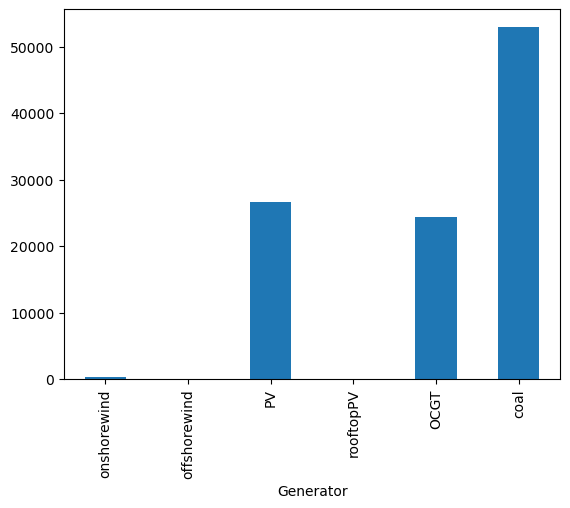

In [7]:
generators = network.generators.p_nom_opt # in MW
generators.plot.bar()

<Axes: ylabel='CF coal'>

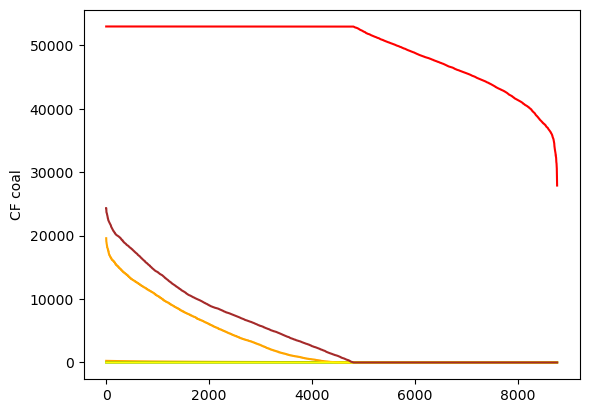

In [28]:
# Duration Curves
cf_onshore = network.generators_t.p['onshorewind'].sort_values(ascending=False,ignore_index=True)
cf_offshore = network.generators_t.p['offshorewind'].sort_values(ascending=False,ignore_index=True)
cf_PV = network.generators_t.p['PV'].sort_values(ascending=False,ignore_index=True)
cf_rooftopPV = network.generators_t.p['rooftopPV'].sort_values(ascending=False,ignore_index=True)
cf_OCGT = network.generators_t.p['OCGT'].sort_values(ascending=False,ignore_index=True)
cf_coal = network.generators_t.p['coal'].sort_values(ascending=False,ignore_index=True)


cf_onshore.plot(kind='line', ylabel='CF onshore', color='orange')
cf_offshore.plot(kind='line', ylabel='CF offshore', color='green')
cf_PV.plot(kind='line', ylabel='CF PV', color='orange')
cf_rooftopPV.plot(kind='line', ylabel='CF rooftopPV', color='yellow')
cf_OCGT.plot(kind='line', ylabel='CF OCGT', color='brown')
cf_coal.plot(kind='line', ylabel='CF coal', color='red')

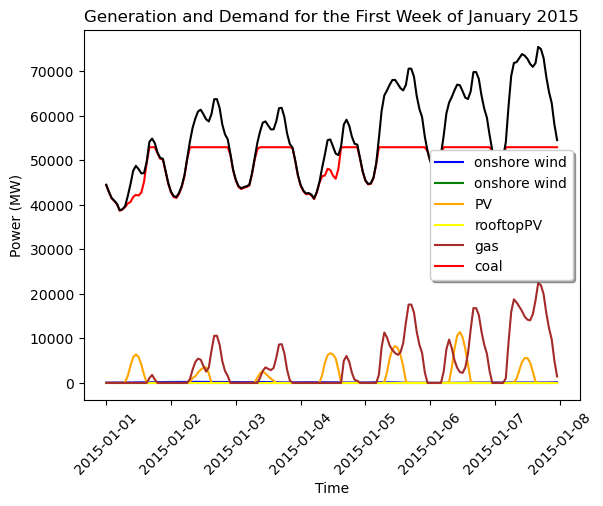

In [8]:
# Plot dispatch for a week in winter
start_date_1 = '2015-01-01'
end_date_1 = '2015-01-07'
week_1 = network.generators_t.p.loc[start_date_1:end_date_1]


plt.plot(week_1['onshorewind'], color='blue', label='onshore wind')
plt.plot(week_1['offshorewind'], color='green', label='onshore wind')
plt.plot(week_1['PV'], color='orange', label='PV')
plt.plot(week_1['rooftopPV'], color='yellow', label='rooftopPV')
plt.plot(week_1['OCGT'], color='brown', label='gas')
plt.plot(week_1['coal'], color='red', label='coal')
plt.legend(fancybox=True, shadow=True, loc='best')
plt.plot(network.loads_t.p['load'].loc[start_date_1:end_date_1], color='black', label='demand')
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.title('Generation and Demand for the First Week of January 2015')

# Rotate x-axis labels
plt.xticks(rotation=45)
plt.show()

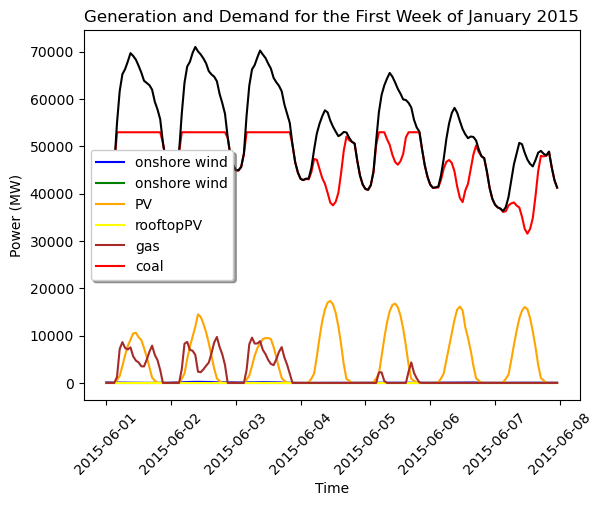

In [9]:
# Plot dispatch for a week in summer
start_date_2 = '2015-06-01'
end_date_2 = '2015-06-07'
week_2 = network.generators_t.p.loc[start_date_2:end_date_2]


plt.plot(week_2['onshorewind'], color='blue', label='onshore wind')
plt.plot(week_2['offshorewind'], color='green', label='onshore wind')
plt.plot(week_2['PV'], color='orange', label='PV')
plt.plot(week_2['rooftopPV'], color='yellow', label='rooftopPV')
plt.plot(week_2['OCGT'], color='brown', label='gas')
plt.plot(week_2['coal'], color='red', label='coal')
plt.legend(fancybox=True, shadow=True, loc='best')
plt.plot(network.loads_t.p['load'].loc[start_date_2:end_date_2], color='black', label='demand')
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.title('Generation and Demand for the First Week of January 2015')

# Rotate x-axis labels
plt.xticks(rotation=45)
plt.show()

In [ ]:
cf = [  network.generators_t.p['onshorewind'].sum(),
        network.generators_t.p['offshorewind'].sum(),
        network.generators_t.p['PV'].sum(),
        network.generators_t.p['rooftopPV'].sum(),
        network.generators_t.p['OCGT'].sum(),
        network.generators_t.p['coal'].sum()]


duration_pv = data_pv.loc['2017-01-01':'2017-12-31'][country].sort_values(ascending=False,ignore_index=True)
duration_pv.plot(kind='line', ylabel='Capacity Factor solar PV', color='orange')

# Section B

In [ ]:
# CO2 emissions in germany (2015): 800.84 million tonnes
# Source: https://ourworldindata.org/co2/country/germany